In [1]:
import os
os.environ['TRKXINPUTDIR']="/global/cfs/projectdirs/atlas/xju/heptrkx/trackml_inputs/train_all"
os.environ['TRKXOUTPUTDIR']= "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/outtest" 

In [2]:
import pkg_resources
import yaml
import pprint
import random
import time
import pickle
random.seed(1234)
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
import matplotlib.cm as cm
import sys
import warnings
warnings.filterwarnings('ignore')
from os import listdir
from os.path import isfile, join
import gc

# %matplotlib widget

sys.path.append('/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/')

# 3rd party
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from trackml.dataset import load_event
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint


# local import
from exatrkx import config_dict # for accessing predefined configuration files
from exatrkx import outdir_dict # for accessing predefined output directories
from exatrkx.src import utils_dir
from exatrkx.src import utils_robust
from utils_robust import *


# for preprocessing
from exatrkx import FeatureStore
from exatrkx.src import utils_torch

# for embedding
from exatrkx import LayerlessEmbedding
from exatrkx.src import utils_torch
from torch_cluster import radius_graph
from utils_torch import build_edges
from embedding.embedding_base import *

# for filtering
from exatrkx import VanillaFilter

# for GNN
import tensorflow as tf
from graph_nets import utils_tf
from exatrkx import SegmentClassifier
import sonnet as snt

# for labeling
from exatrkx.scripts.tracks_from_gnn import prepare as prepare_labeling
from exatrkx.scripts.tracks_from_gnn import clustering as dbscan_clustering

# track efficiency
from trackml.score import _analyze_tracks
from exatrkx.scripts.eval_reco_trkx import make_cmp_plot, pt_configs, eta_configs
from functools import partial

In [3]:
noise_keep = ["0","0.2", "0.4", "0.6", "0.8", "1"]
embed_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/embedding/checkpoints/epoch=10.ckpt'
filter_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/filtering/checkpoints/epoch=92.ckpt'
gnn_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/gnn'
plots_dir = '/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/plots/run1000' # needs to change...
ckpt_idx = -1 # which GNN checkpoint to load
dbscan_epsilon, dbscan_minsamples = 0.25, 2 # hyperparameters for DBScan
min_hits = 5 # minimum number of hits associated with a particle to define "reconstructable particles"
frac_reco_matched, frac_truth_matched = 0.5, 0.5 # parameters for track matching

In [4]:
torch.cuda.is_available()

True

In [5]:
def calc_evts(data_n,rval=1.7,kval=500):
    matched_idx = []
    peta = []
    par_pt = []
    total_times = []
    build_edges = []
    build_graphs = []
    predict_times = []
    filter_times = []
    doub_pur = []
    doub_eff = []
    
    for data in tqdm(data_n):
        
        #############################################
        #                EMBEDDING                  #
        #############################################
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        e_ckpt = torch.load(embed_ckpt_dir, map_location=device)
        e_config = e_ckpt['hyper_parameters']
        e_config['clustering'] = 'build_edges'
        e_config['knn_val'] = kval
        e_config['r_val'] = rval
        e_model = LayerlessEmbedding(e_config).to(device)
        e_model.load_state_dict(e_ckpt["state_dict"])
        e_model.eval()
        
        with torch.no_grad():
            # had to move everything to device
            spatial = e_model(torch.cat([data.cell_data.to(device), data.x.to(device)], axis=-1))
            
        #total_start = time.time()
        
        #############################################
        #               BUILD EDGES                 #
        #############################################
        edges_start = time.time()
        e_spatial = utils_torch.build_edges(spatial.to(device), e_model.hparams['r_val'], e_model.hparams['knn_val'])
        edges_end = time.time()
        
        R_dist = torch.sqrt(data.x[:,0]**2 + data.x[:,2]**2) # distance away from origin...
        e_spatial = e_spatial[:, (R_dist[e_spatial[0]] <= R_dist[e_spatial[1]])]
        
        #############################################
        #              DOUBLET METRICS              #
        #############################################
        e_bidir = torch.cat([data.layerless_true_edges,torch.stack([data.layerless_true_edges[1],
                        data.layerless_true_edges[0]], axis=1).T], axis=-1)
        # did not have to convert e_spatail to tensor??
        e_spatial_n, y_cluster = graph_intersection(e_spatial, e_bidir)
        cluster_true = len(data.layerless_true_edges[0])
        cluster_true_positive = y_cluster.sum()
        cluster_positive = len(e_spatial_n[0])
        pur = cluster_true_positive/cluster_positive
        eff = cluster_true_positive/cluster_true      
        
        #############################################
        #                  FILTER                   #
        #############################################
        f_ckpt = torch.load(filter_ckpt_dir, map_location='cpu')
        f_config = f_ckpt['hyper_parameters']
        f_config['train_split'] = [0, 0, 1]
        f_config['filter_cut'] = 0.18

        f_model = VanillaFilter(f_config).to(device)
        f_model.load_state_dict(f_ckpt['state_dict'])
        f_model.eval()
        
        filter_start = time.time()
        emb = None # embedding information was not used in the filtering stage.
        chunks = 10
        output_list = []
        for j in range(chunks):
            subset_ind = torch.chunk(torch.arange(e_spatial.shape[1]), chunks)[j]
            with torch.no_grad():
                output = f_model(torch.cat([data.cell_data.to(device), data.x.to(device)], axis=-1), e_spatial[:, subset_ind], emb).squeeze()  #.to(device)
            output_list.append(output)
            del subset_ind
            del output
            gc.collect()
        output = torch.cat(output_list)
        output = torch.sigmoid(output)

        # The filtering network assigns a score to each edge. 
        # In the end, edges with socres > `filter_cut` are selected to construct graphs.
        # edge_list = e_spatial[:, output.to('cpu') > f_model.hparams['filter_cut']]
        edge_list = e_spatial[:, output > f_model.hparams['filter_cut']]
        filter_end = time.time()

        #############################################
        #               BUILD GRAPH                 #
        #############################################
        # ### Form a graph
        # Now moving TensorFlow for GNN inference.
        n_nodes = data.x.shape[0]
        n_edges = edge_list.shape[1]
        nodes = data.x.cpu().numpy().astype(np.float32)
        edges = np.zeros((n_edges, 1), dtype=np.float32)
        senders = edge_list[0].cpu()
        receivers = edge_list[1].cpu()

        input_datadict = {
            "n_node": n_nodes,
            "n_edge": n_edges,
            "nodes": nodes,
            "edges": edges,
            "senders": senders,
            "receivers": receivers,
            "globals": np.array([n_nodes], dtype=np.float32)
        }

        input_graph = utils_tf.data_dicts_to_graphs_tuple([input_datadict])

        num_processing_steps_tr = 8
        optimizer = snt.optimizers.Adam(0.001)
        model = SegmentClassifier()

        output_dir = gnn_ckpt_dir
        checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
        ckpt_manager = tf.train.CheckpointManager(checkpoint, directory=output_dir, max_to_keep=10)
        status = checkpoint.restore(ckpt_manager.checkpoints[ckpt_idx]).expect_partial()

        # clean up GPU memory
        del e_spatial
        del e_model
        del f_model
        gc.collect()
        if device == 'cuda':
            torch.cuda.empty_cache()

        graph_start = time.time()
        outputs_gnn = model(input_graph, num_processing_steps_tr)
        output_graph = outputs_gnn[-1]
        graph_end = time.time()
        
        #############################################
        #             TRACK LABELLING               #
        #############################################
        predict_start = time.time()
        input_matrix = prepare_labeling(tf.squeeze(output_graph.edges).cpu().numpy(), senders, receivers, n_nodes)
        predict_tracks = dbscan_clustering(data.hid.cpu(), input_matrix, dbscan_epsilon, dbscan_minsamples)
        # trkx_groups = predict_track_df.groupby(['track_id'])
        # all_trk_ids = np.unique(predict_track_df.track_id)
        # n_trkxs = all_trk_ids.shape[0]
        # predict_tracks = [trkx_groups.get_group(all_trk_ids[idx])['hit_id'].to_numpy().tolist() for idx in range(n_trkxs)]
        predict_end = time.time()
          
        
        #############################################
        #            END-TO-END METRICS             #
        #############################################
        evt_path = data.event_file
        m_idx, pt, p_pt = track_eff(evt_path, predict_tracks,min_hits,frac_reco_matched, frac_truth_matched)
        
        #total_end = time.time()
        
        #############################################
        #               SAVE TO LIST                #
        #############################################
        
        #total_times.append(total_end-total_start)
        build_edges.append(edges_end-edges_start)
        predict_times.append(predict_end-predict_start)
        filter_times.append(filter_end-filter_start)
        build_graphs.append(graph_end-graph_start)
        
        matched_idx.append(m_idx)
        peta.append(pt)
        par_pt.append(p_pt)
        
        doub_pur.append(pur)
        doub_eff.append(eff)
        
    this_dict = {
        'matched_idx' : matched_idx,
        'peta' : peta,
        'par_pt' : par_pt,
        'doublet_purity' : doub_pur,
        'doublet_efficiency' : doub_eff,
        #'total_times' : total_times,
        'build_edges' : build_edges,
        'build_graphs' : build_graphs,
        'filter_times' : filter_times,
        'predict_times' : predict_times
    }
    
    return this_dict

In [6]:
def create_pickle(data_n,rval=1.7,kval=500):
    dictn = calc_evts(data_n,rval,kval)
    with open(f'/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/val/lists_n{rval}.pickle', 'wb') as handle:
        pickle.dump(dictn, handle)

In [42]:
def get_data_np(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))][:20]
    data_n = []
    for file in onlyfiles:
        data = torch.load(join(mypath,file))
        data_n.append(data)
    return data_n

In [8]:
def open_pickle(pickle_dir):
    with open(pickle_dir, 'rb') as handle:
        unpickler = pickle.Unpickler(handle)
        b = unpickler.load()
    return b

In [9]:
r_vals = np.arange(1,2,0.1)
knn_vals = np.arange(400,501,10)

In [10]:
noise_dir = f'/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/layerless_check/n1/feature_store'
data_n = get_data_np(noise_dir)

In [11]:
# for r in r_vals:
#     print(f"------ r_val {r}------")
#     create_pickle(data_n,rval=r)
#     print("--------------------")

  0%|          | 0/5 [00:00<?, ?it/s]

------ r_val 1.0------
Instructions for updating:
Use tf.identity instead.


  0%|          | 0/5 [00:00<?, ?it/s]

--------------------
------ r_val 1.1------


  0%|          | 0/5 [00:00<?, ?it/s]

--------------------
------ r_val 1.2000000000000002------


  0%|          | 0/5 [00:00<?, ?it/s]

--------------------
------ r_val 1.3000000000000003------


  0%|          | 0/5 [00:00<?, ?it/s]

--------------------
------ r_val 1.4000000000000004------


  0%|          | 0/5 [00:00<?, ?it/s]

--------------------
------ r_val 1.5000000000000004------


  0%|          | 0/5 [00:00<?, ?it/s]

--------------------
------ r_val 1.6000000000000005------


  0%|          | 0/5 [00:00<?, ?it/s]

--------------------
------ r_val 1.7000000000000006------


  0%|          | 0/5 [00:00<?, ?it/s]

--------------------
------ r_val 1.8000000000000007------


  0%|          | 0/5 [00:00<?, ?it/s]

--------------------
------ r_val 1.9000000000000008------


100%|██████████| 5/5 [08:29<00:00, 101.84s/it]

--------------------


In [43]:
create_pickle(data_n,rval=2.0)

  0%|          | 0/5 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 760.00 MiB (GPU 0; 15.78 GiB total capacity; 1.52 GiB already allocated; 482.75 MiB free; 1.98 GiB reserved in total by PyTorch)

In [23]:
plt.rcParams.update({'axes.titlesize' : 16, 'axes.labelsize' : 16, 'lines.linewidth' : 2, 'lines.markersize' : 10,
                    'xtick.labelsize' : 14, 'xtick.major.width' : 2,
                    'ytick.labelsize' : 14, 'ytick.major.width' : 2,
                    'grid.alpha' : 0.5, "legend.frameon" : False, 'legend.fontsize' : 16})

In [24]:
def get_pickle_data(pickle_path,n):
    list_data = {}

    list_data[f'{n}'] = open_pickle(pickle_path)

    d = list_data[f'{n}']

    p = d['doublet_purity']
    p = np.mean(p)

    e = d['doublet_efficiency']
    e = np.mean(e)
    
    b = d['build_edges']
    b = np.mean(b)
    
    g = d['build_graphs']
    g = np.mean(g)
    
    return p,e,b,g

In [29]:
pur = []
eff = []
be = []
gt = []
for r in r_vals:
    pickle_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/val/lists_n{r}.pickle"
    p,e,b,g = get_pickle_data(pickle_path,r)
    pur.append(p)
    eff.append(e)
    be.append(b)
    gt.append(g)

In [37]:
import pandas as pd
from pandas import DataFrame as df


In [41]:
d = {'r_val': r_vals, 'Purity' : pur, 'Efficiency' : eff, 'Build Edges (s)': be, 'Build Graphs (s)' : gt}
table = df(data=d)
table

,r_val,Purity,Efficiency,Build Edges (s),Build Graphs (s)
0,1.0,0.113752,0.873765,0.857565,9.558240
1,1.1,0.075929,0.905177,0.722892,11.546320
2,1.2,0.049695,0.927167,0.702571,13.870653
3,1.3,0.032427,0.943087,0.725325,18.418355
4,1.4,0.021423,0.954794,0.730152,23.862278
5,1.5,0.014769,0.963565,0.761790,30.436123
6,1.6,0.010868,0.969652,0.759149,37.895290
7,1.7,0.008489,0.973461,0.719185,44.360780
8,1.8,0.006945,0.975648,0.757529,57.732125
9,1.9,0.005912,0.976991,0.764742,83.665907


Text(0.5, 0.98, 'Change in r_val at 20% noise')

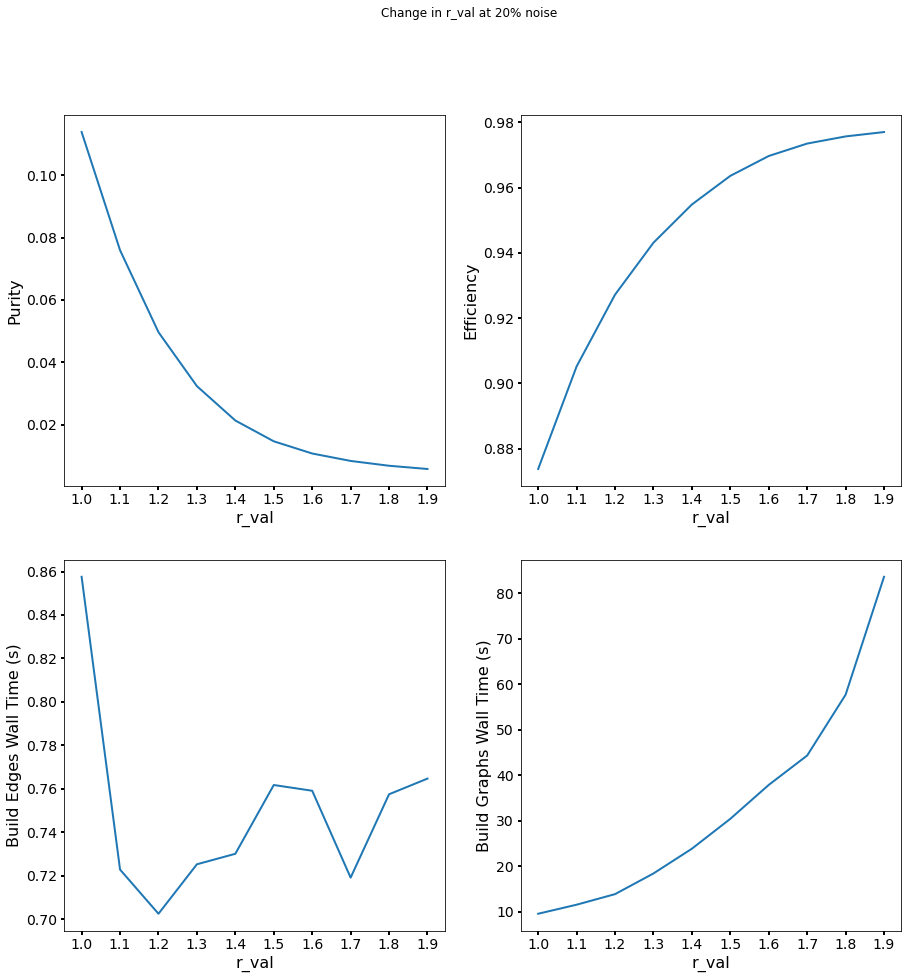

In [32]:
fig,ax = plt.subplots(2,2,figsize = (15,15))

ax[0][0].plot(r_vals,pur)
ax[0][0].set_xlabel('r_val')
ax[0][0].set_ylabel('Purity')
ax[0][0].set_xticks(r_vals)


ax[0][1].plot(r_vals,eff)
ax[0][1].set_xlabel('r_val')
ax[0][1].set_ylabel('Efficiency')
ax[0][1].set_xticks(r_vals)


ax[1][0].plot(r_vals,be)
ax[1][0].set_xlabel('r_val')
ax[1][0].set_ylabel('Build Edges Wall Time (s)')
ax[1][0].set_xticks(r_vals)


ax[1][1].plot(r_vals,gt)
ax[1][1].set_xlabel('r_val')
ax[1][1].set_ylabel('Build Graphs Wall Time (s)')
ax[1][1].set_xticks(r_vals)

fig.suptitle("Change in r_val at 20% noise")